# **GCG Visualization Notebook** Version 1.0
This notebook is part of and serves as an easy entry into the GCG visualization framework. It is structured into

1. **Configuration Section:**  
   Here, you should configure the plot as needed and give the path to the runtime data.
2. **Code Section:**  
   This section does not need to be touched at all. If you want to change behavior, you will however find the well-documented code here.
3. **Main Execution Section:**  
   In this section, the magic happens: Plots are generated and you are asked to conduct your own experiments.

> Please note: This notebook
> - **does not** yet offer all the advanced functionality and plots that the scripts itself would offer. 
> - **does** offer easy customization through good documentation and obvious locations to add own custom code.

_______________________
# Configuration Section
In this section, one can configure where to find the runtime data and what settings to use for the plots.

First, we require you to give the path to your runtime data. It can be given as `.out`-file(s). Independent of the number of files you give, the outfiles must always handed over as list.

If parsing of your large `.out`-file takes long, you can also give a `.pkl`-file of the already parsed `.out`-files.

In [1]:
# Input Data (.out-file or .pkl-file)

# .out-file: the log exported into `check/results/` by GCG's `make test` or `make testcluster` functionality
#            (see https://gcg.or.rwth-aachen.de/doc/conduct-experiments.html#testing)
# An example file can be found in `../doc/resources/misc/runtime_data/`.
outfiles   = ["example_logs/check.short.gcg-3.1.0.linux.x86_64.gnu.opt.spx2.orlab03.or.rwth-aachen.de.default.default.out"]

# .pkl-file: a pickle file (much faster to read than .out-files) exported by the general parser 
#            (see https://gcg.or.rwth-aachen.de/doc/visu-manual.html#general-plotter)
# A pickle file is prioritized if given.
picklefile = "example_logs/strIPlib_30MinutesAndLonger.pkl"

### Time Distribution Plot Settings
#### Mandatory Settings

In [2]:
## Configure which times should be plotted. 
## - All times that are possible are listed in the next section.
## - Not all combinations of times are sensible to plot due to inclusion of times in others. 
##   For more information, see the function correctTimeInclusion(df, times, scip) (down in this notebook) or 
##   in the GCG documentation https://gcg.or.rwth-aachen.de/doc/visu-args.html
times      = ["PRICING TIME", "PRICING SOLVER TIME", "RMP LP TIME", "DETECTION TIME", "ORIGINAL LP TIME", "HEUR TIME ORIG", "HEUR TIME MASTER", "CUTS TIME ORIG", "CUTS TIME MASTER","READING TIME"]

#### Advanced Settings

In [3]:
## Configure more advanced parameters. For beginners, just leave this as it is or use the interactive functionalities (see Main Execution Section).
scale           = "log"
scaling         = False        # scale bars s.t. all have a height of 1
sortByArg       = False       # sort by first given time
sortByDuration  = True        # sort by duration (sensible if normalization is off)
exportFile      = "plot.png"  # file to export the plot to
preprocessTimes = False       # must be activated if the times were not already preprocessed once

Now that all parameters are set, we recommend scrolling down until the "Main Execution Section". There, you will be able to generate plots and craft own ones.

______________
# Code Section
In this section, we define all required code to get you started with your own analysis in the "Main Execution Section". And this
is exactly where you should skip now if you are not planning to change code already.

### Definitions: Packages & Coloring

In [4]:
# In this block, we import required packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [5]:
# In this block, we present the user all possible times.
flist = pd.read_json("misc/feature_descriptions.json", orient="index")

print("The following times can be included in the 'times'-list used for the time distribution plot:")
from IPython.display import display
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10, 'display.max_colwidth', 1000):
    # If the 'contains'-filter is removed, all possible features are shown and can be used for plots other than the time distribution plot.
    display(flist.loc[flist.index.str.contains('TIME')][["clearname", "description"]])

The following times can be included in the 'times'-list used for the time distribution plot:


,clearname,description
TOTAL TIME,Total Time,"Time used for reading, presolving and solving, excluding copying."
READING TIME,Reading Time,Time used for reading of the problem.
COPYING TIME,Copying Time,Time used for copying (e.g. from original to master problem).
DETECTION TIME,Detection Time,Time used for automatic detection of a problem structure.
PRESOLVING TIME,Presolving Time,Time used for presolving of the problem.
ROOT NODE TIME,Time in Root Node,Time spent inside the root node.
HEUR TIME ORIG,Heuristics Time (Original Problem),Time used for heuristics in the original problem.
HEUR TIME MASTER,Heuristics Time (Master Problem),Time used for heuristics in the master problem.
CUTS TIME MASTER,Cuts Time (Master Problem),Time used for finding/applying cutting planes in the master problem.
CUTS TIME ORIG,Cuts Time (Original Problem),Time used for finding/applying cutting planes in the original problem.


In [6]:
# In this block, we define colors to stay consistent over different plots for the most important (most often used) arguments
# Define GCG colorblind-friendly colors as used in the decomposition visualizations
COLOR_WHITE = "#FFFFFF"
COLOR_BLUE1 = "#ACBCE9"
COLOR_BLUE2 = "#718CDB"
COLOR_BLUE3 = "#3C64DD"
COLOR_BLUE4 = "#1340C7"
COLOR_BLUE5 = "#1F377D"
COLOR_ORANGE1 = "#FFD88F"
COLOR_ORANGE2 = "#FFCB69"
COLOR_ORANGE3 = "#FFB72D"
COLOR_BROWN1 = "#B38208"
COLOR_BROWN2 = "#886100"
COLOR_BROWN3 = "#443000"
COLOR_BLACK = "#000000"
# Generate a color map for all times that do not have a fixed color
indexcolormap = cm.get_cmap('rainbow', len(times))
indexcolormap = indexcolormap(np.arange(0,indexcolormap.N))
color_dict = {k: indexcolormap[c] for c, k in enumerate(times)}
# Fix colors for "important" times
color_dict["REMAINING TIME"] = "#000000"
color_dict["PRICING TIME"] = COLOR_ORANGE3
color_dict["PRICING SOLVER TIME"] = COLOR_ORANGE1
color_dict["DETECTION TIME"] = COLOR_BLUE1
color_dict["RMP LP TIME"] = COLOR_BLUE3

### Definitions: Data Reading/Writing & Preprocessing 

In [7]:
def readOutfiles(outfiles, scip = False):
    print(f"Reading outfiles '{outfiles}'...")
    import general.parser_general as parser
    df = parser.parseOutfiles(outfiles)
    if scip:
        df["DEC FILE"] = -1
        df.set_index(["LP FILE"], inplace=True)
    else:
        df.set_index(["LP FILE","DEC FILE"], inplace=True)
    return df

In [8]:
def readDataframe(picklepath, scip = False):
    print(f"Reading pickle '{picklepath}'...")
    df = pd.read_pickle(picklepath)
    if scip:
        df["DEC FILE"] = -1
        df.set_index(["LP FILE"], inplace=True)
    else:
        try: df.set_index(["LP FILE","DEC FILE"], inplace=True)
        except: pass # case: the dataframe was exported by this notebook and already has LP FILE and DEC FILE as index
    df.style.set_caption(picklepath)
    return df

In [9]:
def writeDataframe(df, path="plots/temporary_plotdata.pkl"):
    pd.to_pickle(df[times + ["REMAINING TIME", "TOTAL TIME", "STATUS"]], path)
    return

In [10]:
def correctTimeInclusion(df, times = ["DETECTION TIME", "PRICING SOLVER TIME"], scip = False):
    # default behavior: fix strange time measurements by 
    #                   adding DETECTION TIME to TOTAL TIME, 
    #                   removing PRICING SOLVER TIME from PRICING TIME

    # COPYING TIME and DETECTION TIME is not included in total time (while solving (including presolving) and reading is)
    if "COPYING TIME" in times:
        df["TOTAL TIME"] += df["COPYING TIME"]
    if "DETECTION TIME" in times and not scip:
        df["TOTAL TIME"] += df["DETECTION TIME"]

    # Generally illegal combinations
    if "TOTAL TIME" in times:
        times.pop("TOTAL TIME")
    if "MASTER TIME" in times:
        times.pop("MASTER TIME")
    if "ROOT NODE TIME" in times and ("HEURISTICS TIME MASTER" in times or "CUTS TIME MASTER" in times or "PRICING TIME" in times or "RMP LP TIME" in times):
        print("WARNING: Inclusion unclear. Do not continue with ROOT NODE TIME.")
    
    if scip: return df
    
    # GCG illegal combinations
    if "PRICING SOLVER TIME" in times and "PRICING TIME" in times:
        df["PRICING TIME"] -= df["PRICING SOLVER TIME"]
    
    return df

In [11]:
def preprocessData(df, times, preprocessTimes = True, sortByDuration = False, sortByArg = False, scip = False):
    print(f"Full dataset: {str(len(df))}")

    # PREPROCESSING #
    # replace all NaN by 0 because if e.g. DETECTION TIME = NaN, then no detection took place
    df.fillna(0., inplace=True)
    if preprocessTimes:
        df = correctTimeInclusion(df, times, scip)
    # reduce main dataframe to only plot given times
    plotdata = df[times + ["STATUS"]].copy()
    # initialize REMAINING TIME as TOTAL TIME
    plotdata["REMAINING TIME"] = df["TOTAL TIME"].copy()
    # drop rows with unknown total time
    plotdata = plotdata.loc[~plotdata["REMAINING TIME"].isna()]
    print(" After removing 'total time missing':", str(len(plotdata)))
    # replace all NaNs by 0, since for times this makes sense
    plotdata.fillna(0, inplace=True)
    # drop rows with all zeros
    plotdata = plotdata.loc[~(plotdata==0).all(axis=1)]
    print(" After removing 'all zero rows':", str(len(plotdata)))

    # TIME SUBTRACTION # 
    # subtract all times that are going to be plotted from the REMAINING TIME
    for t in times:
        plotdata["REMAINING TIME"] -= plotdata[t]
    plotdata["TOTAL TIME"] = df["TOTAL TIME"].copy()

    # ERROR CHECKING #
    # check for calculation errors
    margin = 10.0 # tolerance margin
    first_order_errors = len(plotdata[plotdata["REMAINING TIME"] < -margin])
    second_order_errors = len(plotdata[sum(plotdata[time] for time in times) + plotdata["REMAINING TIME"] > plotdata["TOTAL TIME"] + margin])
    if first_order_errors > 0:
        print(f"  {first_order_errors} first order calculation errors found. Removing affected rows.")
        #print(plotdata[plotdata["REMAINING TIME"] < -margin])
        plotdata = plotdata.loc[plotdata["REMAINING TIME"] >= -margin]
        #print(plotdata[plotdata["REMAINING TIME"] < -margin])
    if second_order_errors > 0:
        print(f"  {second_order_errors} second order calculation errors found. Removing affected rows.")
        #print(plotdata[sum(plotdata[time] for time in times) + plotdata["REMAINING TIME"] > plotdata["TOTAL TIME"] + margin])
        plotdata = plotdata.loc[sum(plotdata[time] for time in times) + plotdata["REMAINING TIME"] <= plotdata["TOTAL TIME"] + margin]
    # set negative remaining times to zero 
    plotdata["REMAINING TIME"].clip(lower=0, inplace=True)
    print(" After removing 'calculation errors':", str(len(plotdata)))
    if first_order_errors + second_order_errors > 1000:
        print(" [WARNING] Removed many rows. Did you preprocess your times (if applicable)? If no, set 'preprocessTimes = True' and try again.")

    # SORTING #
    # dataframe sorting according to set argument
    if sortByDuration:
        plotdata.sort_values("TOTAL TIME", inplace=True)
    elif sortByArg:
        plotdata.sort_values(times[0], inplace=True)

    print("Length of data to work with:", str(len(plotdata)))
    return plotdata

### Definitions: Plotting & Viewing

In [12]:
def makePlot(pltdata, scale = "log", scaling = False, exportFile = "plot.png", showTimeouts = True):
    # function that generates simple stacked bar plots of time distribution. 
    pltdata = pltdata.copy()

    # check for timeouts
    if showTimeouts:
        maximum = pltdata["TOTAL TIME"].max() # get maximum value of data subset
        timeout_indices = []
        for i, row in enumerate(pltdata.iterrows()):
            if float(row[1]["TOTAL TIME"]) > 10800:
                timeout_indices.append(i)
 
    # remove total time to not scale over it
    pltdata.drop(columns = ["TOTAL TIME"], axis=0, inplace=True)
    
    # scale data so that bars have equal height 
    if scaling:
        pltdata = pltdata.apply(lambda x: x*100/sum(x), axis=1)

    # make plot
    plt.figure(figsize=(30,10), dpi=100)
    ax = plt.subplot()
    if len(pltdata) > 30: 
        # without tick labels if too many instances
        ax = pltdata[times + ["REMAINING TIME"]].plot(kind = "bar", stacked = True, ax = plt.gca(), xticks=[], color = [color_dict[x] for x in times + ["REMAINING TIME"]])  
        plt.xticks([])
        plt.xlabel("")
    else: 
        # with tick labels if few instances
        ax = pltdata[times + ["REMAINING TIME"]].plot(kind = "bar", stacked = True, ax = plt.gca(), color = [color_dict[x] for x in times + ["REMAINING TIME"]])
        # prettify x axis and x tick labels (LP FILE, DEC FILE pairs)
        xlabels_new = [str(x).replace(",","\n").replace("(","").replace(")","").replace("'","").replace("instances/striplib/","") for x in list(pltdata.index)]
        plt.xticks(range(len(pltdata)), xlabels_new, rotation=90)
        plt.xlabel("Instance File\nDecomposition File")
    
    # create legend
    plt.rcParams['legend.title_fontsize'] = 'x-large'
    plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left', frameon=False, title="\n\nTime Features", fontsize=12)

    # set scale (default: logarithmic)
    plt.yscale(scale)

    # add signs over bars if tuple ran into timeout
    if showTimeouts:
        if scaling: maximum = 100
        for i in timeout_indices:
            ax.text(i,maximum,'+',ha='center', va='bottom', linespacing=3, fontsize=20)

    # export plot to predefined file and show it
    if not exportFile == None: plt.savefig("plots/" + exportFile)
    plt.show()

In [13]:
def startWebview():
    import subprocess
    view = subprocess.Popen(["python","app.py"])
    return view

def updateWebview(df):
    # this command simply performs the writeDataframe function because
    # the webview refreshes automatically if the dataframe is updated
    writeDataframe(df) 
    return

def stopWebview(view):
    view.terminate()
    return

In [14]:
def getTupleDetails(data, search_tuple):
    # function to check details of specific tuples
    # checking by their name only (without full path)
    search_frame = data.reset_index()
    res = search_frame.loc[
        (search_frame["LP FILE"].str.contains(search_tuple[0])) & 
        (search_frame["DEC FILE"] == search_tuple[1])].transpose()
    with pd.option_context('display.max_rows', 100, 'display.max_columns', 10, 'display.max_colwidth', 1000):
        display(res)
    #return res
    

In [15]:
def executeInteractiveFiltering():
    # function to perform interactive filtering with all time arguments through sliders
    # Generates plot and returns all tuples remaining after filtering
    from ipywidgets import interact_manual, interactive_output, interact, Output
    import ipywidgets as widgets

    def pl(time, interval, timeouts, scaling, scale):
        # plotter
        global data
        if timeouts and time == "TOTAL TIME":
            plotdata = data[((interval[0] <= data[time]) & (data[time] <= interval[1])) | (data[time] > 10800)]
        elif timeouts:
            plotdata = data[(interval[0] <= data[time]) & (data[time] <= interval[1])]
        else:
            plotdata = data[(interval[0] <= data[time]) & (data[time] <= interval[1]) & (data["TOTAL TIME"] <= 10800)]
        if len(plotdata) == 0:
            return
        waittext = widgets.HTML(
            value='Generating plot...',
            disabled=False
        )
        im.widget.children[6].layout.display = "flex"
        display(waittext)
        makePlot(plotdata, scale = scale, scaling = scaling, exportFile = None)
        waittext.layout.display = "none"
        return

    def f(time, interval, timeouts):
        # backend
        if time == "TOTAL TIME" and interval[1] != 10800:
            timeouts = False
            include_timeouts.value = False
            include_timeouts.disabled = True
        else:
            include_timeouts.disabled = False
        global data
        global plotdata
        if timeouts and time == "TOTAL TIME":
            plotdata = data[((interval[0] <= data[time]) & (data[time] <= interval[1])) | (data[time] > 10800)]
        elif timeouts:
            plotdata = data[(interval[0] <= data[time]) & (data[time] <= interval[1])]
        else:
            plotdata = data[(interval[0] <= data[time]) & (data[time] <= interval[1]) & (data["TOTAL TIME"] <= 10800)]
        ntuples = len(plotdata)
        if ntuples == 0:
            print("No tuples found (filter too restrictive).")
            return
        elif ntuples < 50:
            print("Found", ntuples, "tuples:")
            for i_d in plotdata.index.to_list(): 
                print("", i_d)
        else:
            print("Found", ntuples, "tuples (not displaying).")
        updateWebview(plotdata)
        return

    # define the two sliders
    lower_bound_widget = widgets.IntSlider(min=0, max=10800, step=300, value=0)
    upper_bound_widget = widgets.IntSlider(min=0, max=10800, step=300, value=10800)
    # give pandas dataframe as time, since it will lead to a drop down selection on all columns
    times_drop_down = widgets.Dropdown(options = sorted(data.columns), value="TOTAL TIME", description="Time:", layout={"width": "400px"})
    interval_slider = widgets.IntRangeSlider(value=[1080, 10800], min=0, max=10800, step=300, description='Interval:', layout={"width": "400px"})
    include_timeouts = widgets.Checkbox(value=False, description='Include Timeouts', indent=True, disabled=False)
    scaling_toggle = widgets.Checkbox(value=False, description='Scale to 1', indent=True)
    scale_dropdown = widgets.RadioButtons(options=["log","linear"], description='Axis Scale:', indent=True)

    # define hidden widgets
    times_drop_down2 = widgets.Dropdown(options = sorted(data.columns), value="TOTAL TIME")
    times_drop_down2.layout.display = 'none'
    interval_slider2 = widgets.IntRangeSlider(value=[1080, 10800], min=0, max=10800, step=300)
    interval_slider2.layout.display = 'none'
    include_timeouts2 = widgets.Checkbox(value=False, description='Include Timeouts', indent=True, disabled=False)
    include_timeouts2.layout.display = 'none'

    lA = widgets.link((times_drop_down, 'value'), (times_drop_down2, 'value'))
    lB = widgets.link((interval_slider, 'value'), (interval_slider2, 'value'))
    lB = widgets.link((include_timeouts, 'value'), (include_timeouts2, 'value'))

    # define interactive menu

    # plotting function (only called when button clicked)
    im = interact_manual(pl, time=times_drop_down, 
                        interval = interval_slider,
                        timeouts = include_timeouts,
                        scaling = scaling_toggle,
                        scale = scale_dropdown)
    im.widget.children[5].description = 'Generate Plot'
    im.widget.children[5].layout.width = "400px"  
    
    # button to hide plot
    button = widgets.Button(description="Hide Plot", layout={"width": "400px"})
    display(button)
    def on_button_clicked(b):
        im.widget.children[6].layout.display = "none"  
    button.on_click(on_button_clicked)

    # continous backend (generates list of tuples continously)
    im2 = interact(f, time=times_drop_down2, 
                        interval = interval_slider2,
                        timeouts = include_timeouts2)
    global plotdata
    return

------------------------
------------------------
# Main Execution Section
In this section, we demonstrate all functionality so that you can use it for your own experiments. This means that you will get
- a web view started on [http://127.0.0.1:5000/](http://127.0.0.1:5000/)
- a `png` visualization into the `plots/` folder, called by the name defined with `exportFile` (default: `plot.png`)
- an interactive filtering functionality (see below).

## General Plotter (Time Distribution)

In [16]:
# Start web view on http://127.0.0.1:5000/ and remember its process ID to terminate later on
view = startWebview()

In [17]:
# Read input data:
# If you gave a pickle, read that. 
# Note: If that pickle was exported using this notebook, leave the time inclusion correction disabled, else you will get negative times. 
if picklefile != "":
    preprocessTimes = False # set to True if the pickle you read was generated using the general parser
    df = readDataframe(picklefile)
# Else, your input was an `.out`-file, so read that using the parser in general/parser_general.py
else:
    preprocessTimes = True
    df = readOutfiles(outfiles)

# Preprocess (including sorting, not including scaling)
global data
data = preprocessData(df, times, preprocessTimes = preprocessTimes, sortByDuration = sortByDuration, sortByArg = sortByArg)

# Push to web view
updateWebview(data)

Reading pickle 'example_logs/strIPlib_30MinutesAndLonger.pkl'...
Full dataset: 1260
 After removing 'total time missing': 1260
 After removing 'all zero rows': 1260
 After removing 'calculation errors': 1260
Length of data to work with: 1260


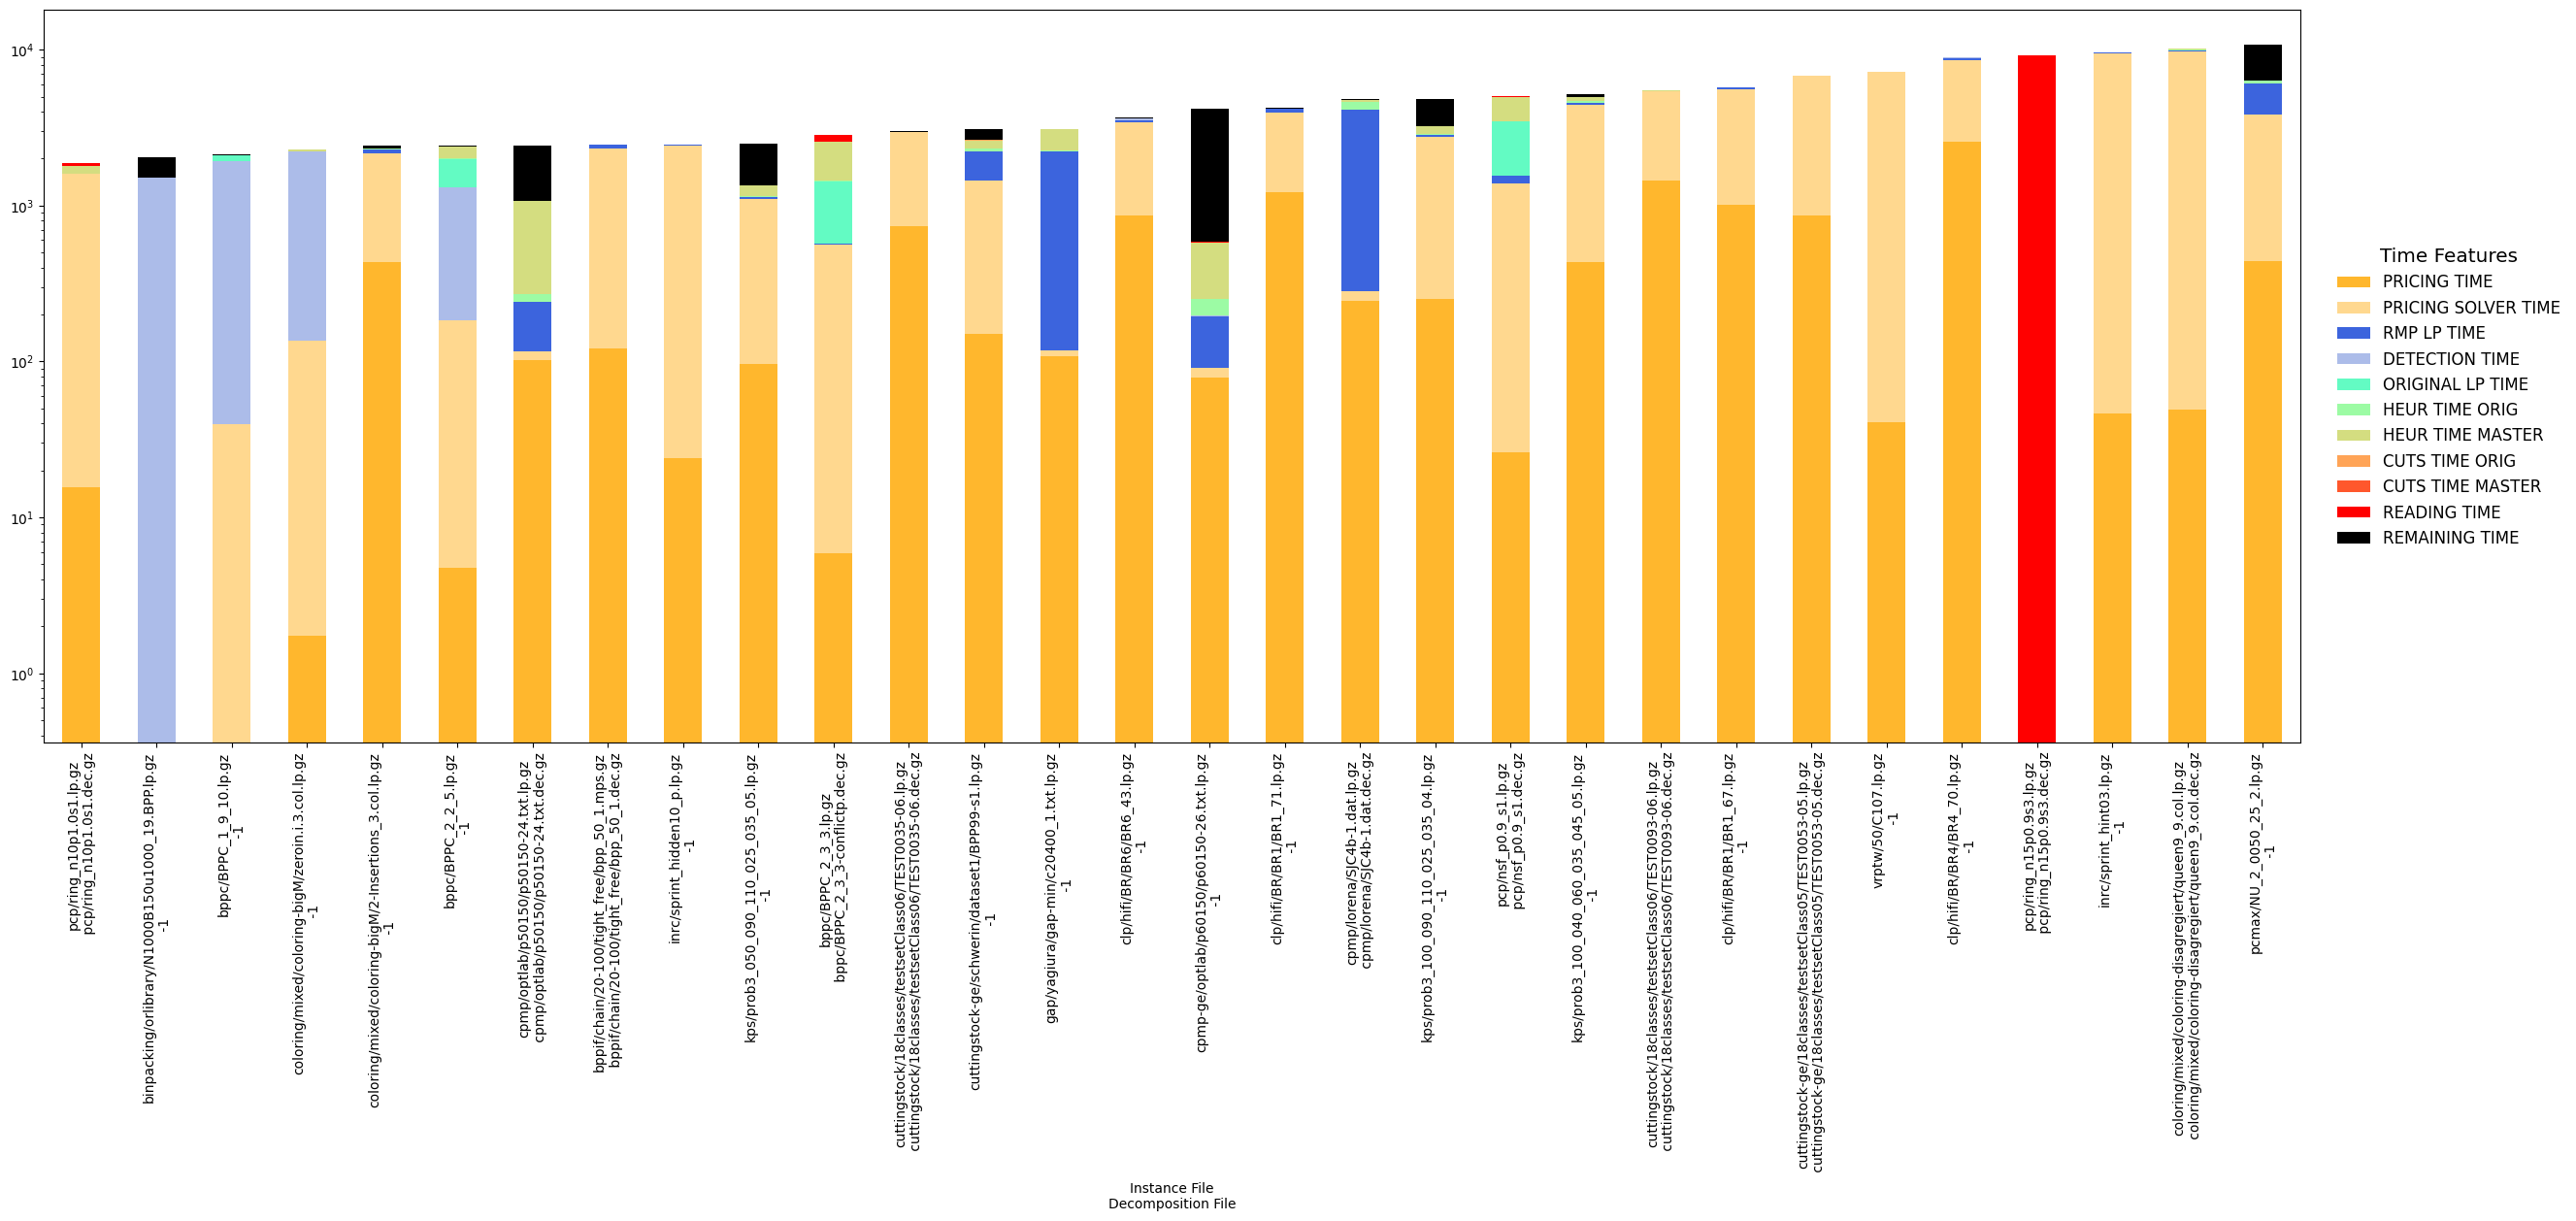

In [18]:
# Sample uniformly from the data to get a first impression.
makePlot(data.sample(30).sort_values("TOTAL TIME"), scale = scale, scaling = scaling, exportFile = None)

In [19]:
# Initiate interactive filtering.
# The filtered data will continously be pushed to webview (refresh page to get the new plot).
executeInteractiveFiltering()

interactive(children=(Dropdown(description='Time:', index=12, layout=Layout(width='400px'), options=('CUTS TIM…

Button(description='Hide Plot', layout=Layout(width='400px'), style=ButtonStyle())

interactive(children=(Dropdown(description='time', index=12, layout=Layout(display='none'), options=('CUTS TIM…

> In the above example, we want to see the distribution of the detection time. To only get interesting examples, we set a custom interval, starting with instances that took at least half an hour in detection.<br>
> Naturally, we only get instances where no decomposition was given beforehand (that's what the `-1` stands for). In the given plot, it is suspicious that the second to last instance seems to only have been in the detection phase.<br>
> Since the given list is in the correct order, we can simply copy the respective line and take a closer look into how the exact numbers are looking.

In [20]:
# Get details of specific tuples
search_tuple = ('instances/striplib/clp/tsai/BR/BR1/BR1_56.lp.gz', -1)
getTupleDetails(data, search_tuple)

,1218
LP FILE,instances/striplib/clp/tsai/BR/BR1/BR1_56.lp.gz
DEC FILE,-1
PRICING TIME,0.0
PRICING SOLVER TIME,0.0
RMP LP TIME,0.0
DETECTION TIME,10472.66
ORIGINAL LP TIME,0.0
HEUR TIME ORIG,0.0
HEUR TIME MASTER,0.0
CUTS TIME ORIG,0.0


> We see that indeed, the detection time was quite high. However, we should always **check for the status of the solving**, especially if we do not trust the numbers (or limit plots to a successful status only).<br>
> That is sensible because sometimes, instances abort and make the data unreliable or allow for false conclusions. We look up the meaning of all possible statuses.

In [21]:
flist.loc["STATUS"]["description"]

'Status after solving terminated. 0: unknown, 1: solved (optimal), 2: solved (infeasible), 3: time limit, 4: memory limit, 5: node limit.'

> With this little reminder, we now know that GCG **terminated with unknown status** (i.e. with status code `0`) on this instance. This typically means that it **ran into a hard limit**, e.g. the time limit.<br>
> With this knowledge, we could e.g. tweak the detection of GCG to abort at some point and to allow for the solving to at least start.

In [22]:
# Terminate web view using the process ID saved in view
stopWebview(view)

## Tree Statistics Plotter

100%|██████████| 2728/2728 [00:04<00:00, 631.51it/s]


Calculating depths
Generating plot of instance example_logs/vbc/p18


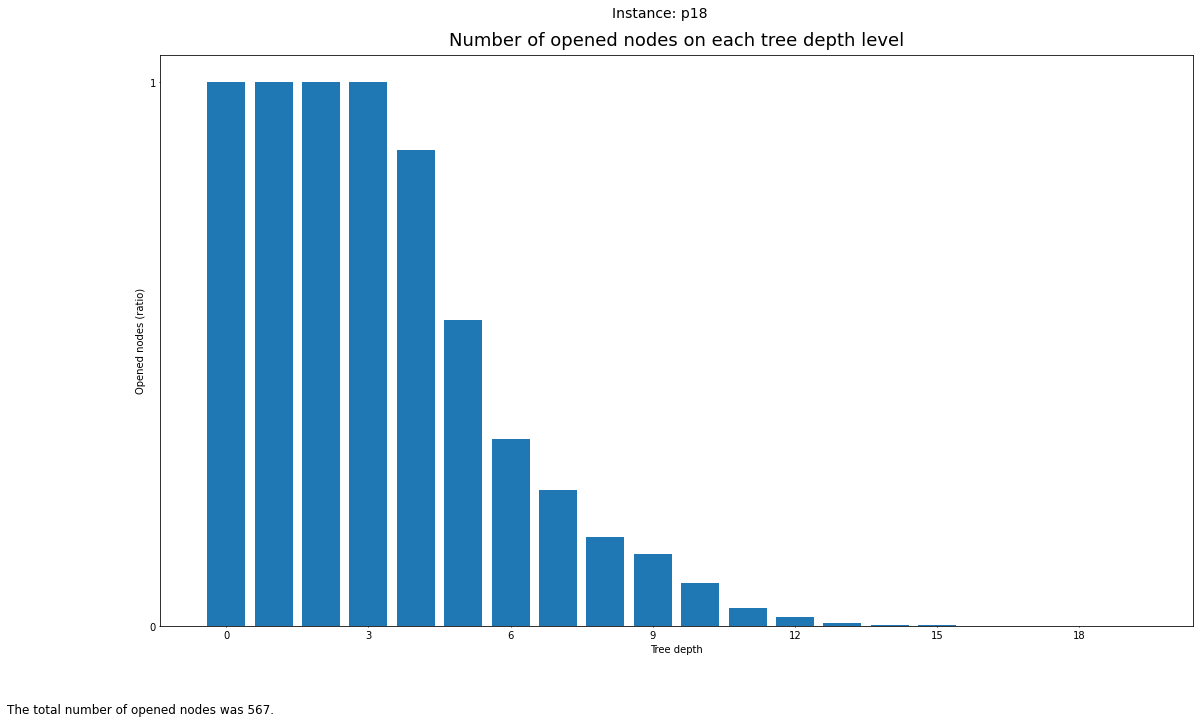

In [23]:
###############################
### Tree Statistics Plotter ###
###############################
import tree.plotter_tree as tree_plotter

# .vbc-file: a file branch-and-bound tree information including exported by GCG if the test was run with STATISTICS=true. 
#            (see https://gcg.or.rwth-aachen.de/doc/visu-manual.html#tree-plotter)
vbcfile = "example_logs/vbc/p18.default_feature.vbc"

# Define arguments required for the plotter
settings = vbcfile.split('.')[-2]
instance = '.'.join(vbcfile.split('.')[:-2])
visusettings = {"normalize": True,   # for each level in the tree, scale bar to the maximal possible size
                "type": "bar",       # plot barchart only 
                "outdir": None,      # export to this folder. set to None to disable file export
                "interactive": True} # makes the function return the *still modifiable* plot

# Read tree information file (vbc file)
vbc_df, treeinfo = tree_plotter.vbcr.read(vbcfile)
# Calculate the number of iterations per depth level
tree_data = tree_plotter.calc_itperdepth(vbc_df)

# Generate plot
print(f"Generating plot of instance {instance}")
treeplot = tree_plotter.plot(tree_data, instance, settings, visusettings)

## Bounds Plotter

Generating Bounds Plot...


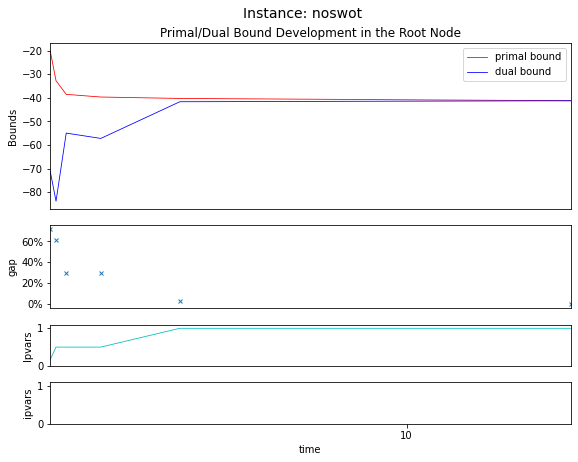

In [28]:
######################
### Bounds Plotter ###
######################
import bounds.parser_bounds as parser_bounds
import bounds.plotter_bounds as plotter_bounds

# .out-file: the log exported into `check/results/` by GCG's `make test` or `make testcluster` functionality
#            (see https://gcg.or.rwth-aachen.de/doc/conduct-experiments.html#testing)
# An example file can be found in `../doc/resources/misc/runtime_data/`.
# Important: For the bounds plotter, the data has to have been generated with the flag `STATISTICS=true`. 
files = ["example_logs/check.short.gcg-3.1.0.linux.x86_64.gnu.opt.spx2.orlab05.or.rwth-aachen.de.default.default.out"]

# Define arguments required for the plotter
visusettings = plotter_bounds.set_params(plotter_bounds.parse_arguments(files)) # get default values
# Change settings at your discretion (print dict visusettings to get a clue of what is possible)
visusettings['interactive'] = True
visusettings['xaxis'] = "time" # what to put on the xaxis of the plot (time or iter for iterations)

# Read the bounds data using the bounds parser.
# The returned data is as defined on the documentation page 
# (see https://gcg.or.rwth-aachen.de/doc/visu-args.html#bounds-args)
df_dict, set_dict = parser_bounds.generate_files(files, visusettings)

# Generate plot
print("Generating Bounds Plot...")
plotlist = dict(plotter_bounds.generate_visu(visusettings["filename"], df_dict = df_dict, set_dict = set_dict, params = visusettings))
p1 = plotlist["noswot"]
p1.set_facecolor('white')
p1

## Experiment 1
**Experiment Brief:** (Add brief experiment description here)  
**Experiment Environment:**
  - Test Set: (Add test set here)
  - System: (Add system here)
  - Limits: (Add time, memory and node limit here)

In [25]:
# TODO: Read own experiment data using df = readOutfiles([outfile1, ...])
# TODO: Preprocess the data using data = preprocessData(df)
# TODO: Implement own, custom visualizations and plot with them
# ...